# This notebook is for the development of a pipeline for unsupervised learning on accelerometer data. A public dataset is used, since the eventual intended dataset for the project is not available yet.

## The dataset used in this notebook is the FORTH_TRACE_DATASET 

### Katerina Karagiannaki, Athanasia Panousopoulou, & Panagiotis Tsakalides. (2016). The FORTH-TRACE dataset for human activity recognition of simple activities and postural transitions using a Body Area Network [Data set]. Zenodo. http://doi.org/10.5281/zenodo.841301

The dataset is collected from 15 participants wearing 5 Shimmer sensor nodes 
on the locations listed in Table 1. The participants performed a series of 16 
activities (7 basic and 9 postural transitions), listed in Table 2.

The captured signals are the following:
3-axis accelerometer
3-axis gyroscope
3-axis magnetometer

The sampling rate of the devices is set to 51.2 Hz.

--------------------------------------------------------------------------------
		DATASET FILES
--------------------------------------------------------------------------------
The dataset contains the following files:

partX/partXdev1.csv
partX/partXdev2.csv
partX/partXdev3.csv
partX/partXdev4.csv
partX/partXdev5.csv

Where X corresponds to the participant ID, 
and numbers 1-5 to the device ID (Table 1).

Each .csv file has the following format:

Column1: Device ID
Column2: accelerometer x
Column3: accelerometer y
Column4: accelerometer z
Column5: gyroscope x
Column6: gyroscope y
Column7: gyroscope z
Column8: magnetometer x
Column9: magnetometer y
Column10: magnetometer z
Column11: Timestamp
Column12: Activity Label

--------------------------------------------------------------------------------
		Table 1: LOCATIONS
--------------------------------------------------------------------------------
1. Left Wrist
2. Right Wrist
3. Torso
4. Right Thigh
5. Left Ankle

--------------------------------------------------------------------------------
		Table 2: ACTIVITY LABELS
--------------------------------------------------------------------------------
(Arrows (->) indicate transitions between activities)

1. stand 
2. sit 
3. sit and talk 
4. walk 
5. walk and talk 
6. climb stairs (up/down) 
7. climb stairs (up/down) and talk 
8. stand -> sit 
9. sit -> stand 
10. stand -> sit and talk 
11. sit and talk -> stand 
12. stand -> walk 
13. walk -> stand 
14. stand -> climb stairs (up/down), stand -> climb stairs (up/down) and talk 
15. climb stairs (up/down) -> walk 
16. climb stairs (up/down) and talk -> walk and talk 

### Part 0: Imports

In [1]:
import math
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
import pyhsmm
import pyhsmm.basic.distributions as distributions
from pyhsmm.util.text import progprint_xrange
import statistics 
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### Part 1: Data parsing

In [2]:
data_location = "/home/jack/data/FORTH_TRACE_DATASET-master"

# Creates strings for parsing over the file structure of the dataset
participant_IDs = ["part" + str(x) for x in range(15)]
device_IDs = ["dev" + str(x) for x in range(1,6)]

column_names = ["Device ID", "accelerometer x", "accelerometer y", "accelerometer z",
                "gyroscope x", "gyroscope y", "gyroscope z",
                "magnetometer x", "magnetometer y", "magnetometer z",
                "Timestamp", "Activity Label"]

# The data from all devices and participants is stored into a dictionary
forth_trace_data = {}
for participant in participant_IDs:
    for device in device_IDs:
        forth_trace_data[participant+device] = pd.read_csv(r'{0}/{1}/{1}{2}.csv'.format(data_location, participant, device),
                                                           header = 0,
                                                           names = column_names).drop_duplicates(subset=['Timestamp'])

### Part 2: Basic plotting

In [3]:
# The data from device 1 (left wrist) is taken from the first participant.
part0_dev1 = forth_trace_data["part0dev1"]

# Creates subset dataframes based on standing sitting and walking
#part0dev1_stand_sit_walk = part0_dev1.loc[part0_dev1["Activity Label"].isin([1, 2, 4])]
part0_dev1_stand = part0_dev1.loc[part0_dev1["Activity Label"] == 1]
part0_dev1_sit = part0_dev1.loc[part0_dev1["Activity Label"] == 2]
part0_dev1_walk = part0_dev1.loc[part0_dev1["Activity Label"] == 4]

# converts the timestamp data from ms to second
timestamp_total_seconds = [x / 1000 for x in part0_dev1["Timestamp"]]
timestamp_stand_seconds = [x / 1000 for x in part0_dev1_stand["Timestamp"]]
timestamp_sit_seconds = [x / 1000 for x in part0_dev1_sit["Timestamp"]]
timestamp_walk_seconds = [x / 1000 for x in part0_dev1_walk["Timestamp"]]

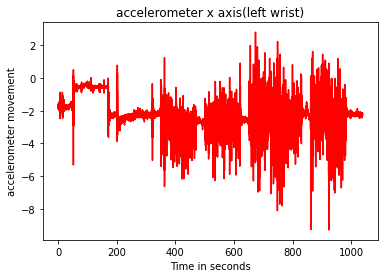

In [4]:
plt.plot(timestamp_total_seconds, part0_dev1["accelerometer x"], color="red")
plt.title("accelerometer x axis(left wrist)")
plt.xlabel("Time in seconds")
plt.ylabel("accelerometer movement")
plt.show()

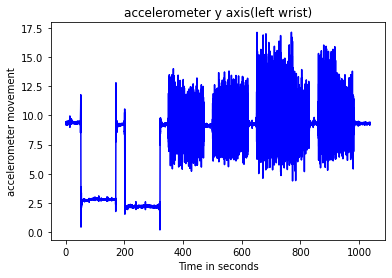

In [5]:
plt.plot(timestamp_total_seconds, part0_dev1["accelerometer y"], color="blue")
plt.title("accelerometer y axis(left wrist)")
plt.xlabel("Time in seconds")
plt.ylabel("accelerometer movement")
plt.show()

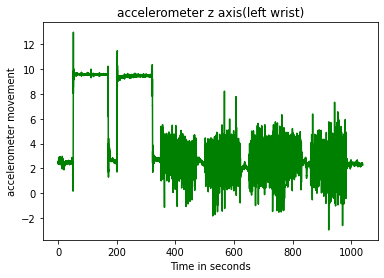

In [6]:
plt.plot(timestamp_total_seconds, part0_dev1["accelerometer z"], color="green")
plt.title("accelerometer z axis(left wrist)")
plt.xlabel("Time in seconds")
plt.ylabel("accelerometer movement")
plt.show()

### Part 3: Windows

The data of each participant is split into windows of a certain amount of seconds

In [7]:
# The sampling rate of the devices
hertz = 51.2
# the size of the windows in seconds
window_length = 5
nrows_per_window = int(window_length / (1 / hertz))

In [8]:
windows_per_part = []
all_windows = []
for participant in participant_IDs:
    # FOR NOW only the device on the torso is used
    #torso_data = forth_trace_data[participant+"dev3"]
    
    thigh_data = forth_trace_data[participant+"dev4"]
    
    # Splits the data from the participant into a list of windows.
    windows = [thigh_data[i:i+nrows_per_window] for i in range(0,thigh_data.shape[0],nrows_per_window)]
    
    windows_per_part.append(windows)
    all_windows += windows

### Part 4: Features

In [118]:
def calc_ENMO(x, y, z):
    # Returns the Euclidean Norm Minus One (ENMO). Calculated from three given values: X, Y and Z
    total_accel = math.sqrt(x**2 + y**2 + z**2)
    return np.clip(total_accel - 1, 0, None)


def calc_mean_ENMO(dataset):
    # Returns the mean total acceleration of a given set of data
    return statistics.mean(dataset.apply(lambda row: calc_ENMO(row["accelerometer x"],
                                                               row["accelerometer y"],
                                                               row["accelerometer z"]), axis=1))


def calc_sensor_orientation(main_axis, second_axis, third_axis):
    # Returns the orientation of a accelerometer sensor axis relative to the horizontal plane.
    return math.degrees(math.atan(main_axis / math.sqrt(second_axis**2 + third_axis**2)))


def calc_mean_sensor_orientation(dataset, main_axis, second_axis, third_axis):
    # Returns the mean the orientation of a accelerometer sensor axis relative to the horizontal plane.
    return statistics.mean(dataset.apply(lambda row: calc_sensor_orientation(row["accelerometer {}".format(main_axis)],
                                                                             row["accelerometer {}".format(second_axis)],
                                                                             row["accelerometer {}".format(third_axis)]), axis=1))


def extract_features(dataset):
    # returns the extracted features from the given dataset
    mean_ENMO = calc_mean_ENMO(dataset)
    mean_angle_x = calc_mean_sensor_orientation(dataset, "x", "y", "z")
    mean_angle_y = calc_mean_sensor_orientation(dataset, "y", "x", "z")
    mean_angle_z = calc_mean_sensor_orientation(dataset, "z", "y", "x")    
    return [mean_ENMO, mean_angle_x, mean_angle_y, mean_angle_z]


def get_minmax(input_list):
    # Returns the minimum and maximum of a given list
    return [min(input_list), max(input_list)]
    
    
def minmax_norm(x, xmin, xmax):
    # Normalizes data(x) using the min max approach, given the minimum and maximum of the total data
    return ((x - xmin) / (xmax - xmin))

In [119]:
# The minimum and maximum values of the features of all windows combined are calculated.
# This is needed for min max normalization

ENMO_list = [calc_mean_ENMO(window) for window in all_windows]
min_ENMO, max_ENMO = get_minmax(ENMO_list)

angle_x_list = [calc_mean_sensor_orientation(window, "x", "y", "z") for window in all_windows]
min_angle_x, max_angle_x = get_minmax(angle_x_list)

angle_y_list = [calc_mean_sensor_orientation(window, "y", "x", "z") for window in all_windows]
min_angle_y, max_angle_y = get_minmax(angle_y_list)

angle_z_list = [calc_mean_sensor_orientation(window, "z", "y", "x") for window in all_windows]
min_angle_z, max_angle_z = get_minmax(angle_z_list)

In [120]:
features_per_part = []
for participant in windows_per_part:

    ENMO_per_part = []
    anglex_per_part = []
    angley_per_part = []
    anglez_per_part = []
    labels = []
    timestamps = []
    
    for window in participant:
        # the label for the window is the mode of the labels in the window
        labels.append(stats.mode(window["Activity Label"].to_numpy())[0][0])
        # the timestamp for the window is the initial timestamp
        timestamps.append(window["Timestamp"].iloc[0])

        enmo, anglex, angley, anglez = extract_features(window)
        
        ENMO_per_part.append(enmo)
        anglex_per_part.append(anglex)
        angley_per_part.append(angley)
        anglez_per_part.append(anglez)

    # The ENMO is normalized using min max normalization.
    ENMO_per_part_norm = [minmax_norm(part, min_ENMO, max_ENMO) for part in ENMO_per_part]
    
    anglex_per_part_norm = [minmax_norm(part, min_angle_x, max_angle_x) for part in anglex_per_part]
    
    angley_per_part_norm = [minmax_norm(part, min_angle_y, max_angle_y) for part in angley_per_part]
    
    anglez_per_part_norm = [minmax_norm(part, min_angle_z, max_angle_z) for part in anglez_per_part]
    

    data = {'ENMO':  ENMO_per_part_norm,
            'anglex':  anglex_per_part_norm,
            'angley':  angley_per_part_norm, 
            'anglez':  anglez_per_part_norm, 
            'labels': labels}
    
    # The features are put into a new dataframe
    feature_dataframe = pd.DataFrame (data, 
                                      columns = ['ENMO', 'anglex', 'angley', 'anglez', 'labels'], 
                                      index= timestamps)
    
    features_per_part.append(feature_dataframe)

In [121]:
data_example = features_per_part[0]
data_example.head()

ENMO    anglex    angley    anglez  labels
1328.6   0.052964  0.333108  0.966744  0.247922       1
6328.6   0.053855  0.346114  0.969662  0.259061       1
11329.0  0.059604  0.339388  0.959377  0.273096       1
16329.0  0.049181  0.307708  0.949203  0.242809       1
21329.0  0.054125  0.322351  0.957846  0.232933       1

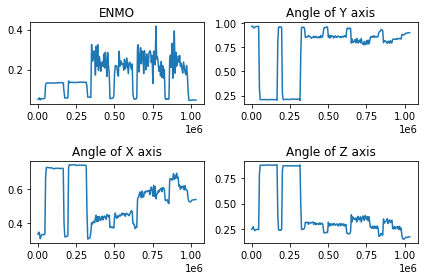

In [122]:
fig, ax = plt.subplots(2, 2)

ax[0,0].title.set_text('ENMO')
ax[0,0].plot(data_example["ENMO"])

ax[1,0].title.set_text('Angle of X axis')
ax[1,0].plot(data_example["anglex"])

ax[0,1].title.set_text('Angle of Y axis')
ax[0,1].plot(data_example["angley"])

ax[1,1].title.set_text('Angle of Z axis')
ax[1,1].plot(data_example["anglez"])

fig.tight_layout()

In [123]:
# This is how data fend into the model looks like
data_example_no_labels = data_example.iloc[0:, 0:4]
data_example_no_labels.head()

ENMO    anglex    angley    anglez
1328.6   0.052964  0.333108  0.966744  0.247922
6328.6   0.053855  0.346114  0.969662  0.259061
11329.0  0.059604  0.339388  0.959377  0.273096
16329.0  0.049181  0.307708  0.949203  0.242809
21329.0  0.054125  0.322351  0.957846  0.232933

<AxesSubplot:>

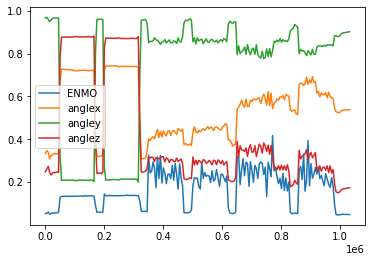

In [124]:
data_example_no_labels.plot()

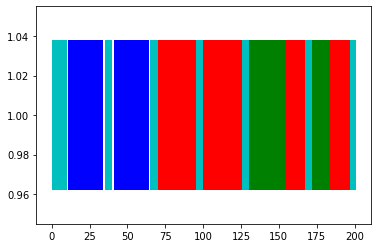

In [125]:
# construct some data
labels = data_example["labels"]
n = len(data_example)
x = np.arange(n+1)           # resampledTime
y = "1" * n   # modulusOfZeroNormalized

label_color_dict = {1 : "c", 2 : "b", 3 : "b", 4 : "r", 5 : "r", 6 : "g", 7 : "g", 8 : "w", 9 : "w"
                   , 10 : "w", 11 : "w", 12 : "w", 13 : "w", 14 : "w", 15 : "w", 16 : "w"}

# set up colors 
c = [label_color_dict[x] for x in labels]

# convert time series to line segments
lines = [((x0,y0), (x1,y1)) for x0, y0, x1, y1 in zip(x[:-1], y[:-1], x[1:], y[1:])]
colored_lines = LineCollection(lines, colors=c, linewidths=(150,))

# Creates a plot that shows the label for each window.
fig, ax = plt.subplots(1)
ax.add_collection(colored_lines)
ax.autoscale_view()
plt.show()

### Part 5: PyHSMM testing

### Initial run

The parameters for this inital run follows what is recommended by the pyhsmm github.
Taken from examples/hsmm.py

In [126]:
# Dimension of the input data
obs_dim = len(data_example_no_labels.columns)
# Max number of states generated
Nmax = 25

In [127]:
obs_hypparams = {'mu_0':np.zeros(obs_dim),
                'sigma_0':np.eye(obs_dim),
                'kappa_0':0.25,
                'nu_0':obs_dim+2}
dur_hypparams = {'alpha_0':2*30,
                 'beta_0':2}

In [128]:
obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]
dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

In [129]:
run1_posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
        alpha=6.,gamma=6., # these can matter; see concentration-resampling.py
        init_state_concentration=6., # pretty inconsequential
        obs_distns=obs_distns,
        dur_distns=dur_distns)

In [130]:
for participant in features_per_part:
    run1_posteriormodel.add_data(participant.iloc[0:, 0:4])

In [131]:
for idx in progprint_xrange(150):
    run1_posteriormodel.resample_model()

.........................  [  25/150,    1.01sec avg, ETA 02:06 ]
.........................  [  50/150,    1.01sec avg, ETA 01:41 ]
.........................  [  75/150,    0.99sec avg, ETA 01:14 ]
.........................  [ 100/150,    0.97sec avg, ETA 48.49 ]
.........................  [ 125/150,    0.96sec avg, ETA 23.98 ]
.........................  [ 150/150,    0.96sec avg, ETA 0.00 ]

   0.96sec avg, 02:23 total



<Figure size 432x288 with 0 Axes>

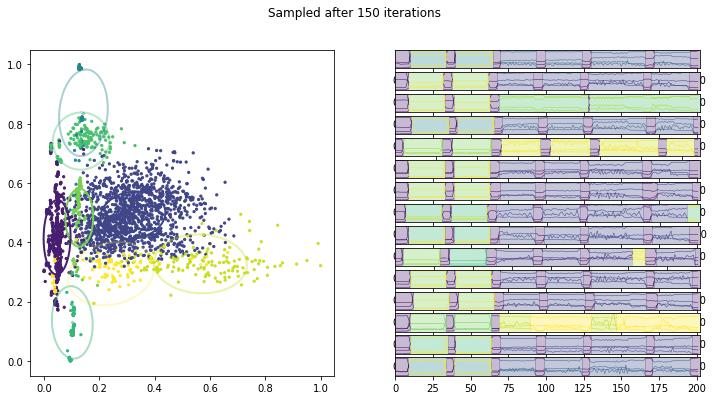

In [132]:
plt.figure()
run1_posteriormodel.plot()
plt.gcf().suptitle('Sampled after 150 iterations')
plt.show()

### Second run

Test the effect of lowering the max number of states

In [133]:
# Max number of states generated
Nmax3 = 3
Nmax4 = 4
Nmax5 = 5

In [134]:
obs_distns_Nmax3 = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax3)]
dur_distns_Nmax3 = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax3)]

obs_distns_Nmax4 = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax4)]
dur_distns_Nmax4 = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax4)]

obs_distns_Nmax5 = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax5)]
dur_distns_Nmax5 = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax5)]

In [135]:
run2_posteriormodel_Nmax3 = pyhsmm.models.WeakLimitHDPHSMM(
    alpha=6.,gamma=6., # these can matter; see concentration-resampling.py
    init_state_concentration=6., # pretty inconsequential
    obs_distns=obs_distns_Nmax3,
    dur_distns=dur_distns_Nmax3)

run2_posteriormodel_Nmax4 = pyhsmm.models.WeakLimitHDPHSMM(
    alpha=6.,gamma=6., # these can matter; see concentration-resampling.py
    init_state_concentration=6., # pretty inconsequential
    obs_distns=obs_distns_Nmax4,
    dur_distns=dur_distns_Nmax4)

run2_posteriormodel_Nmax5 = pyhsmm.models.WeakLimitHDPHSMM(
    alpha=6.,gamma=6., # these can matter; see concentration-resampling.py
    init_state_concentration=6., # pretty inconsequential
    obs_distns=obs_distns_Nmax5,
    dur_distns=dur_distns_Nmax5)

In [136]:
for participant in features_per_part:
    run2_posteriormodel_Nmax3.add_data(participant.iloc[0:, 0:4])
    run2_posteriormodel_Nmax4.add_data(participant.iloc[0:, 0:4])
    run2_posteriormodel_Nmax5.add_data(participant.iloc[0:, 0:4])

In [137]:
for idx in progprint_xrange(150):
    run2_posteriormodel_Nmax3.resample_model()
    
for idx in progprint_xrange(150):
    run2_posteriormodel_Nmax4.resample_model()
    
for idx in progprint_xrange(150):
    run2_posteriormodel_Nmax5.resample_model()

.........................  [  25/150,    0.14sec avg, ETA 17.98 ]
.........................  [  50/150,    0.15sec avg, ETA 14.58 ]
.........................  [  75/150,    0.15sec avg, ETA 11.29 ]
.........................  [ 100/150,    0.15sec avg, ETA 7.70 ]
.........................  [ 125/150,    0.15sec avg, ETA 3.74 ]
.........................  [ 150/150,    0.15sec avg, ETA 0.00 ]

   0.15sec avg, 22.08 total

.........................  [  25/150,    0.15sec avg, ETA 19.32 ]
.........................  [  50/150,    0.16sec avg, ETA 15.78 ]
.........................  [  75/150,    0.16sec avg, ETA 12.01 ]
.........................  [ 100/150,    0.16sec avg, ETA 7.97 ]
.........................  [ 125/150,    0.16sec avg, ETA 4.03 ]
.........................  [ 150/150,    0.17sec avg, ETA 0.00 ]

   0.17sec avg, 25.37 total

.........................  [  25/150,    0.22sec avg, ETA 27.51 ]
.........................  [  50/150,    0.23sec avg, ETA 23.39 ]
......................

<Figure size 432x288 with 0 Axes>

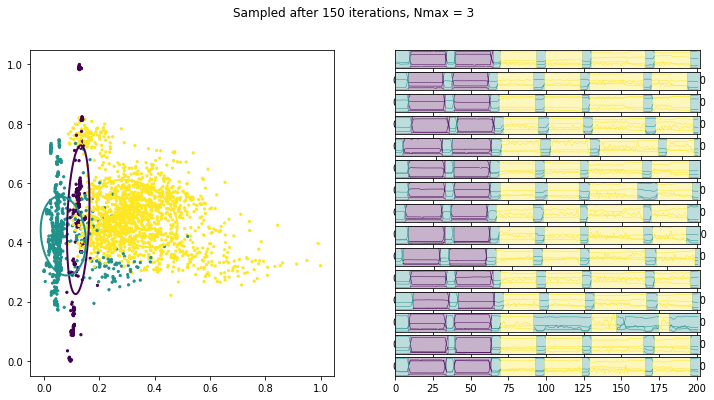

In [138]:
plt.figure()
run2_posteriormodel_Nmax3.plot()
plt.gcf().suptitle('Sampled after 150 iterations, Nmax = 3')
plt.show()

<Figure size 432x288 with 0 Axes>

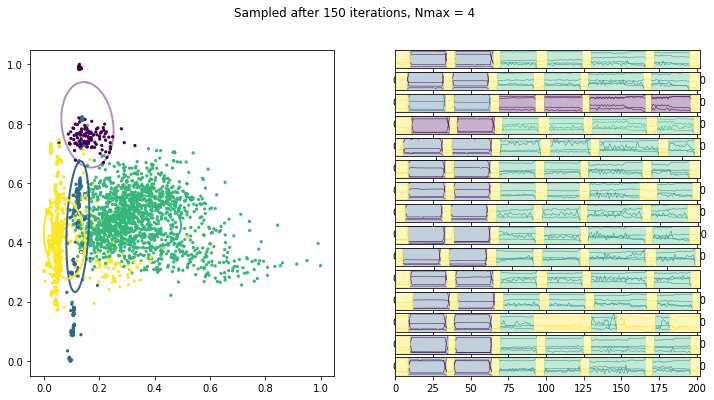

In [139]:
plt.figure()
run2_posteriormodel_Nmax4.plot()
plt.gcf().suptitle('Sampled after 150 iterations, Nmax = 4')
plt.show()

<Figure size 432x288 with 0 Axes>

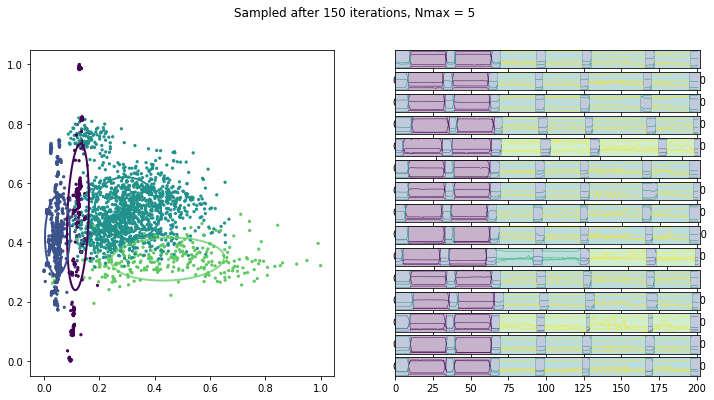

In [140]:
plt.figure()
run2_posteriormodel_Nmax5.plot()
plt.gcf().suptitle('Sampled after 150 iterations, Nmax = 5')
plt.show()

### Third run

Removal of a few participants

In [104]:
participant_subset = features_per_part.copy()
del participant_subset[7]
del participant_subset[12]

In [105]:
run3_posteriormodel_Nmax3 = pyhsmm.models.WeakLimitHDPHSMM(
        alpha=6.,gamma=6., # these can matter; see concentration-resampling.py
        init_state_concentration=6., # pretty inconsequential
        obs_distns=obs_distns_Nmax3,
        dur_distns=dur_distns_Nmax3)

run3_posteriormodel_Nmax4 = pyhsmm.models.WeakLimitHDPHSMM(
        alpha=6.,gamma=6., # these can matter; see concentration-resampling.py
        init_state_concentration=6., # pretty inconsequential
        obs_distns=obs_distns_Nmax4,
        dur_distns=dur_distns_Nmax4)

run3_posteriormodel_Nmax5 = pyhsmm.models.WeakLimitHDPHSMM(
        alpha=6.,gamma=6., # these can matter; see concentration-resampling.py
        init_state_concentration=6., # pretty inconsequential
        obs_distns=obs_distns_Nmax5,
        dur_distns=dur_distns_Nmax5)

In [106]:
for participant in participant_subset:
    run3_posteriormodel_Nmax3.add_data(participant.iloc[0:, 0:4])
    run3_posteriormodel_Nmax4.add_data(participant.iloc[0:, 0:4])
    run3_posteriormodel_Nmax5.add_data(participant.iloc[0:, 0:4])

In [107]:
for idx in progprint_xrange(150):
    run3_posteriormodel_Nmax3.resample_model()
    
for idx in progprint_xrange(150):
    run3_posteriormodel_Nmax4.resample_model()
    
for idx in progprint_xrange(150):
    run3_posteriormodel_Nmax5.resample_model()

.........................  [  25/150,    0.25sec avg, ETA 30.80 ]
.........................  [  50/150,    0.23sec avg, ETA 23.37 ]
.........................  [  75/150,    0.23sec avg, ETA 17.35 ]
.........................  [ 100/150,    0.23sec avg, ETA 11.73 ]
.........................  [ 125/150,    0.24sec avg, ETA 5.89 ]
.........................  [ 150/150,    0.23sec avg, ETA 0.00 ]

   0.23sec avg, 35.21 total

.........................  [  25/150,    0.27sec avg, ETA 33.54 ]
.........................  [  50/150,    0.27sec avg, ETA 27.27 ]
.........................  [  75/150,    0.28sec avg, ETA 20.77 ]
.........................  [ 100/150,    0.28sec avg, ETA 14.24 ]
.........................  [ 125/150,    0.29sec avg, ETA 7.24 ]
.........................  [ 150/150,    0.28sec avg, ETA 0.00 ]

   0.28sec avg, 42.53 total

.........................  [  25/150,    0.21sec avg, ETA 26.21 ]
.........................  [  50/150,    0.21sec avg, ETA 21.41 ]
....................

<Figure size 432x288 with 0 Axes>

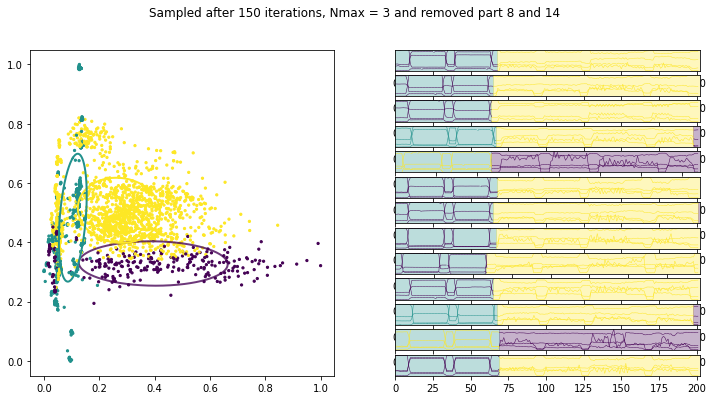

In [108]:
plt.figure()
run3_posteriormodel_Nmax3.plot()
plt.gcf().suptitle('Sampled after 150 iterations, Nmax = 3 and removed part 8 and 14')
plt.show()

<Figure size 432x288 with 0 Axes>

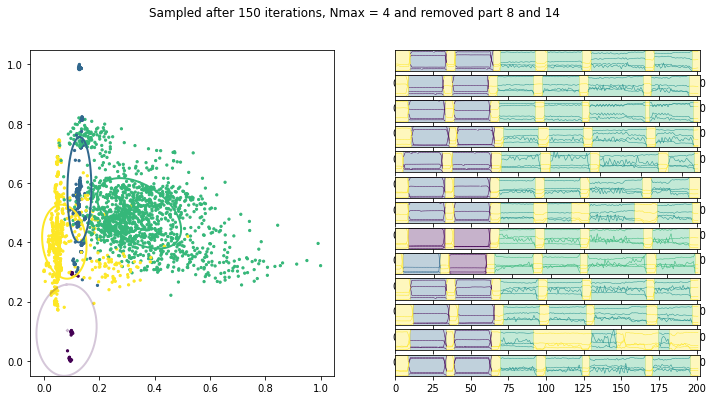

In [109]:
plt.figure()
run3_posteriormodel_Nmax4.plot()
plt.gcf().suptitle('Sampled after 150 iterations, Nmax = 4 and removed part 8 and 14')
plt.show()

<Figure size 432x288 with 0 Axes>

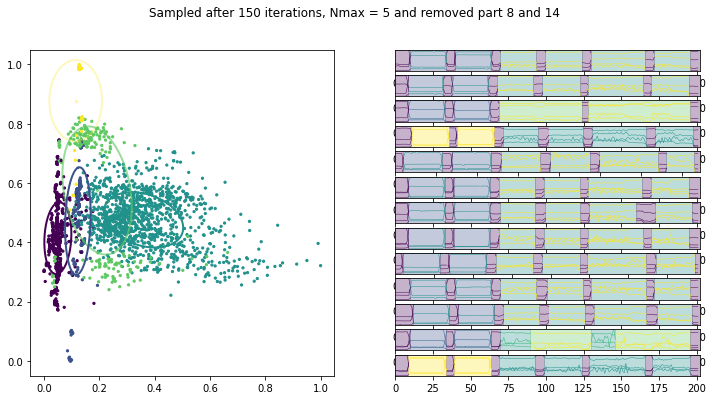

In [110]:
plt.figure()
run3_posteriormodel_Nmax5.plot()
plt.gcf().suptitle('Sampled after 150 iterations, Nmax = 5 and removed part 8 and 14')
plt.show()

### Fourth run

Only using the first four participants

In [111]:
participant_subset2 = features_per_part[0:4]

In [112]:
run4_posteriormodel_Nmax3 = pyhsmm.models.WeakLimitHDPHSMM(
        alpha=6.,gamma=6., # these can matter; see concentration-resampling.py
        init_state_concentration=6., # pretty inconsequential
        obs_distns=obs_distns_Nmax3,
        dur_distns=dur_distns_Nmax3)

run4_posteriormodel_Nmax4 = pyhsmm.models.WeakLimitHDPHSMM(
        alpha=6.,gamma=6., # these can matter; see concentration-resampling.py
        init_state_concentration=6., # pretty inconsequential
        obs_distns=obs_distns_Nmax4,
        dur_distns=dur_distns_Nmax4)

run4_posteriormodel_Nmax5 = pyhsmm.models.WeakLimitHDPHSMM(
        alpha=6.,gamma=6., # these can matter; see concentration-resampling.py
        init_state_concentration=6., # pretty inconsequential
        obs_distns=obs_distns_Nmax5,
        dur_distns=dur_distns_Nmax5)

In [113]:
for participant in participant_subset2:
    run4_posteriormodel_Nmax3.add_data(participant.iloc[0:, 0:4])
    run4_posteriormodel_Nmax4.add_data(participant.iloc[0:, 0:4])
    run4_posteriormodel_Nmax5.add_data(participant.iloc[0:, 0:4])

In [114]:
for idx in progprint_xrange(150):
    run4_posteriormodel_Nmax3.resample_model()
    
for idx in progprint_xrange(150):
    run4_posteriormodel_Nmax4.resample_model()
    
for idx in progprint_xrange(150):
    run4_posteriormodel_Nmax5.resample_model()

.........................  [  25/150,    0.04sec avg, ETA 4.84 ]
.........................  [  50/150,    0.04sec avg, ETA 4.24 ]
.........................  [  75/150,    0.04sec avg, ETA 3.27 ]
.........................  [ 100/150,    0.04sec avg, ETA 2.19 ]
.........................  [ 125/150,    0.04sec avg, ETA 1.09 ]
.........................  [ 150/150,    0.04sec avg, ETA 0.00 ]

   0.04sec avg, 6.55 total

.........................  [  25/150,    0.05sec avg, ETA 6.22 ]
.........................  [  50/150,    0.05sec avg, ETA 4.91 ]
.........................  [  75/150,    0.05sec avg, ETA 3.67 ]
.........................  [ 100/150,    0.05sec avg, ETA 2.48 ]
.........................  [ 125/150,    0.05sec avg, ETA 1.26 ]
.........................  [ 150/150,    0.05sec avg, ETA 0.00 ]

   0.05sec avg, 7.74 total

.........................  [  25/150,    0.06sec avg, ETA 7.52 ]
.........................  [  50/150,    0.06sec avg, ETA 5.92 ]
.........................  [  75

<Figure size 432x288 with 0 Axes>

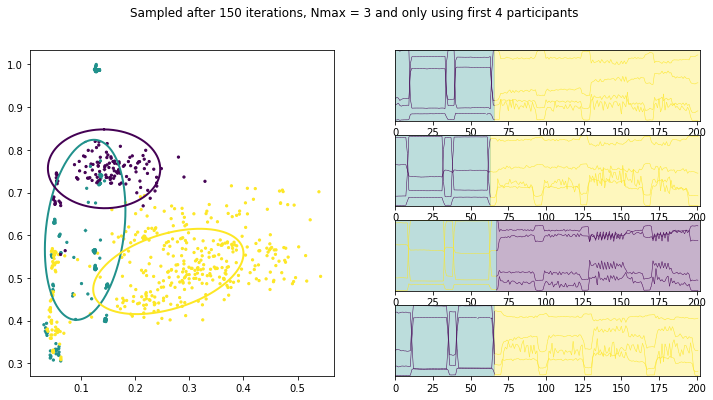

In [115]:
plt.figure()
run4_posteriormodel_Nmax3.plot()
plt.gcf().suptitle('Sampled after 150 iterations, Nmax = 3 and only using first 4 participants')
plt.show()

<Figure size 432x288 with 0 Axes>

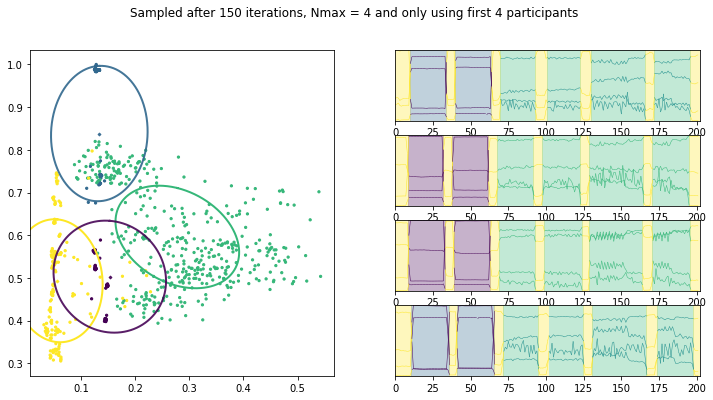

In [116]:
plt.figure()
run4_posteriormodel_Nmax4.plot()
plt.gcf().suptitle('Sampled after 150 iterations, Nmax = 4 and only using first 4 participants')
plt.show()

<Figure size 432x288 with 0 Axes>

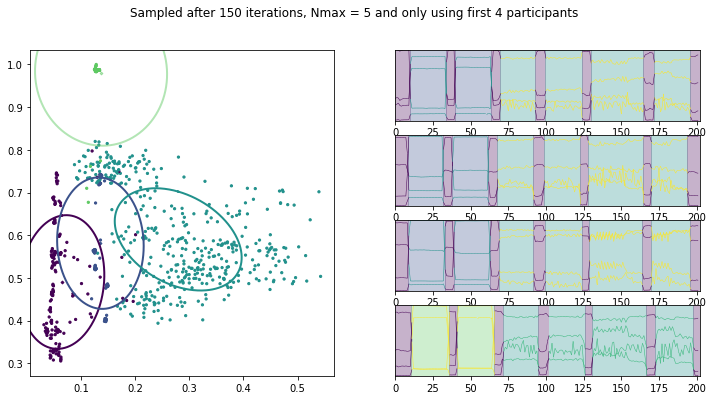

In [117]:
plt.figure()
run4_posteriormodel_Nmax5.plot()
plt.gcf().suptitle('Sampled after 150 iterations, Nmax = 5 and only using first 4 participants')
plt.show()

### Fifth run

This fifth run uses parameters based on the hsmm4acc package used for the van Kuppevelt paper

In [99]:
def initialize_model(Nmax, dim):
    """
    Initialize a HSMM model.
    Parameters
    ------
    Nmax : int, optional
        Maximum number of states
    dim : int
        The number of channels
    Returns
    ------
    model : pyhsmm model
        The initial model
    """
    obs_hypparams = {'mu_0': np.zeros(dim),  # mean of gaussians
                     'sigma_0': np.eye(dim),  # std of gaussians
                     'kappa_0': 0.3,
                     'nu_0': dim + 5
                     }

    # duration is going to be poisson, so prior is a gamma distribution
    # (params alpha beta)
    expected_lam = 12 * 30
    dur_hypparams = {'alpha_0': 2 * expected_lam,
                     'beta_0': 2}

    obs_distns = [distributions.Gaussian(**obs_hypparams)
                  for state in range(Nmax)]
    dur_distns = [
        distributions.PoissonDuration(
            **dur_hypparams) for state in range(
            Nmax)]
    model = pyhsmm.models.WeakLimitHDPHSMM(
        alpha=6., gamma=6.,  # priors
        init_state_concentration=6.,  # alpha0 for the initial state
        obs_distns=obs_distns,
        dur_distns=dur_distns)
    return model

In [100]:
kuppevelt_model = initialize_model(10, obs_dim)

for participant in participant_subset:
    kuppevelt_model.add_data(participant.iloc[0:, 0:4], trunc=720)
    
for idx in progprint_xrange(150):
    kuppevelt_model.resample_model() 

.........................  [  25/150,    0.46sec avg, ETA 57.43 ]
.........................  [  50/150,    0.44sec avg, ETA 44.11 ]
.........................  [  75/150,    0.43sec avg, ETA 32.30 ]
.........................  [ 100/150,    0.43sec avg, ETA 21.68 ]
.........................  [ 125/150,    0.44sec avg, ETA 10.89 ]
.........................  [ 150/150,    0.45sec avg, ETA 0.00 ]

   0.45sec avg, 01:08 total



<Figure size 432x288 with 0 Axes>

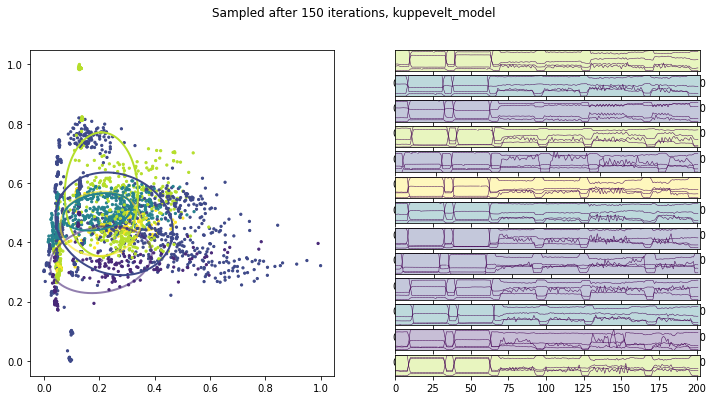

In [101]:
plt.figure()
kuppevelt_model.plot()
plt.gcf().suptitle('Sampled after 150 iterations, kuppevelt_model')
plt.show()

In [102]:
kuppevelt_model = initialize_model(4, obs_dim)

for participant in participant_subset:
    kuppevelt_model.add_data(participant.iloc[0:, 0:4], trunc=25)
    
for idx in progprint_xrange(150):
    kuppevelt_model.resample_model() 

.........................  [  25/150,    0.11sec avg, ETA 14.22 ]
.........................  [  50/150,    0.11sec avg, ETA 11.06 ]
.........................  [  75/150,    0.11sec avg, ETA 8.27 ]
.........................  [ 100/150,    0.11sec avg, ETA 5.47 ]
.........................  [ 125/150,    0.11sec avg, ETA 2.84 ]
.........................  [ 150/150,    0.13sec avg, ETA 0.00 ]

   0.13sec avg, 19.88 total



<Figure size 432x288 with 0 Axes>

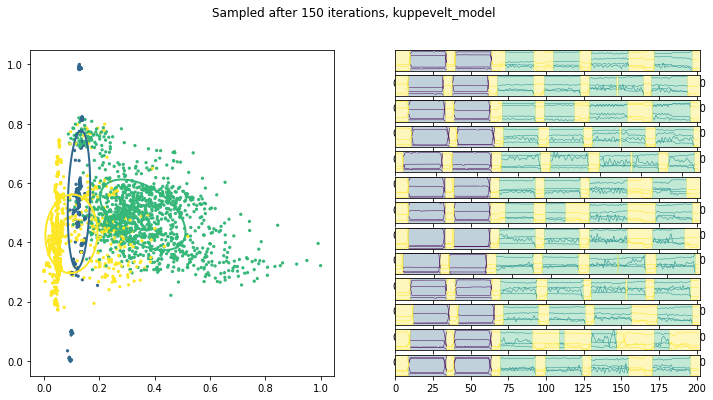

In [103]:
plt.figure()
kuppevelt_model.plot()
plt.gcf().suptitle('Sampled after 150 iterations, kuppevelt_model')
plt.show()

### Part 6: Analysis

labels:
1. stand
2. sit
3. sit and talk
4. walk
5. walk and talk
6. climb stairs (up/down)
7. climb stairs (up/down) and talk
8. stand -> sit
9. sit -> stand
10. stand -> sit and talk
11. sit and talk -> stand
12. stand -> walk
13. walk -> stand
14. stand -> climb stairs (up/down), stand -> climb stairs (up/down) and talk
15. climb stairs (up/down) -> walk
16. climb stairs (up/down) and talk -> walk and talk

In [141]:
model = run2_posteriormodel_Nmax3

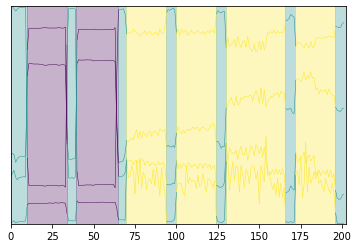

In [142]:
model.plot_stateseq(0)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 1], dtype=int32)

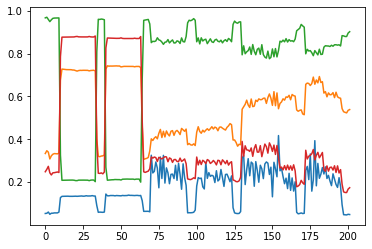

In [143]:
for x in run2_posteriormodel_Nmax3.datas:
    plt.plot(x)
    break
    
state_sequence_per_part = [x for x in model.stateseqs]

state_sequence_per_part[0]

<AxesSubplot:>

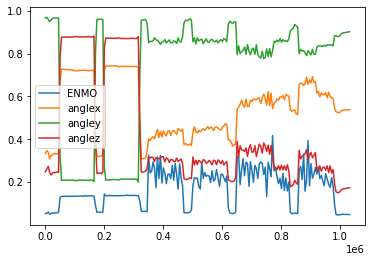

In [144]:
data_example_no_labels.plot()

In [145]:
from collections import Counter
Counter(state_sequence_per_part[0])

Counter({1: 45, 0: 49, 2: 108})

In [146]:
def transform_labels(labels):
    transformed_labels = []
    for x in labels:
        if x == 1:
            transformed_labels.append("stand")
        elif (x == 2) or (x == 3):
            transformed_labels.append("sit")
        elif 4 <= x <= 7:
            transformed_labels.append("walk")
        elif 8 <= x <= 16:
            transformed_labels.append("transition")
    return transformed_labels

transformed_labels = [transform_labels(x['labels']) for x in features_per_part]

Counter(transformed_labels[0])

Counter({'stand': 39, 'transition': 4, 'sit': 46, 'walk': 113})

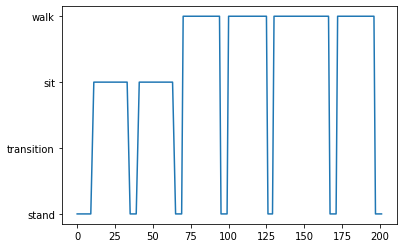

In [147]:
plt.plot(transformed_labels[0])

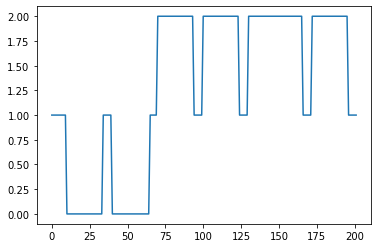

In [148]:
plt.plot(state_sequence_per_part[0])

In [149]:
def transform_states(state_sequence):
    transformed_states = []
    for x in state_sequence:
        if x == 1:
            transformed_states.append("stand")
        elif x == 0:
            transformed_states.append("sit")
        elif x == 2:
            transformed_states.append("walk")
    return transformed_states

transformed_states = [transform_states(x) for x in state_sequence_per_part]

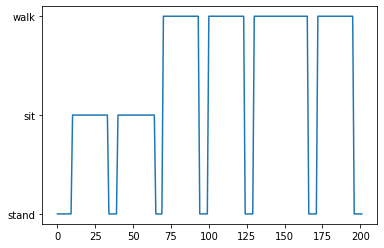

In [150]:
plt.plot(transformed_states[0])

In [151]:
def get_score(labels, states):
    score = []
    count = 0
    transitions = 0
    for label in labels:
        if label == states[count]:
            score.append(1)
        elif label == "transition":
            transitions += 1
        else:
            score.append(0)
            print(label, states[count])
        count +=1
    return score, count - transitions

In [152]:
scores = []
count = 0
for x in range(15):
    labels = transformed_labels[x]
    states = transformed_states[x]
    score, total = get_score(labels, states)
    print("--------------")
    scores.append(Counter(score)[1] / total * 100)

walk stand
walk stand
walk stand
walk stand
walk stand
--------------
walk stand
walk stand
walk stand
walk stand
walk stand
walk stand
stand walk
walk stand
walk stand
--------------
walk stand
stand walk
stand walk
walk stand
--------------
walk stand
walk stand
walk stand
walk stand
stand walk
walk stand
walk stand
stand walk
walk stand
--------------
walk stand
walk stand
walk stand
stand walk
--------------
walk stand
walk stand
stand walk
walk stand
stand walk
walk stand
--------------
walk stand
walk stand
walk stand
walk stand
walk stand
walk stand
walk stand
walk stand
walk stand
walk stand
walk stand
walk stand
walk stand
--------------
walk stand
stand walk
walk stand
--------------
walk stand
walk stand
stand walk
walk stand
walk stand
walk stand
walk stand
walk stand
--------------
stand walk
walk stand
stand walk
stand walk
walk stand
--------------
stand walk
walk stand
stand walk
walk stand
walk stand
--------------
walk stand
walk stand
walk stand
walk stand
walk stand

In [153]:
scores

[97.47474747474747,
 95.40816326530613,
 97.96954314720813,
 95.43147208121827,
 97.76536312849163,
 96.93877551020408,
 93.43434343434343,
 98.46938775510205,
 95.87628865979381,
 97.36842105263158,
 97.46192893401016,
 97.43589743589743,
 66.83673469387756,
 95.93908629441624,
 96.95431472081218]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7d62823100>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7d628237c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7d62813d60>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7d62823e80>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7d6282c220>],
 'means': []}

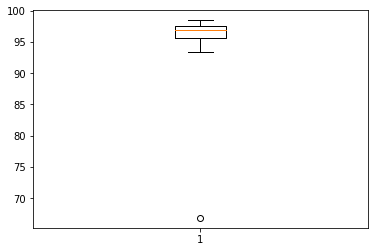

In [154]:
plt.boxplot(scores)